# **Electrical motor fault prediction** :

### source : https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, the data provided by the UCI repository is a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of their knowledge. The dataset consists of 10 000 data points stored as rows with 10 features in columns:

 * **UID**: unique identifier ranging from 1 to 10000;




* **Product ID:** consisting of a letter L, M, or H for low (60% of all products), medium (30%) and high (10%) as product quality variants and a variant-specific serial number;
* **Air temperature [K]:** generated using a random walk process later normalized to a standard deviation of 2 K around 300 K;
* **Process temperature [K]:** generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K;
* **Rotational speed [rpm]:** calculated from a power of 2860 W, overlaid with a normally distributed noise;
* **Torque [Nm]:** torque values are normally distributed around 40 Nm with a standard deviation of 10 Nm and no negative values;
* **Tool wear [min]:** The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process;
* **Machine failure:**label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true. The machine failure consists of five independent failure modes:
* **tool wear failure (TWF):** the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins;
* **heat dissipation failure (HDF):** heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm;

* **power failure (PWF):**the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails;

* **overstrain failure (OSF):** if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain;
* **random failures (RNF):**each process has a chance of 0,1 % to fail regardless of its process parameters. If at least one of the above failure modes is true, the process fails and the ’machine failure’ label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

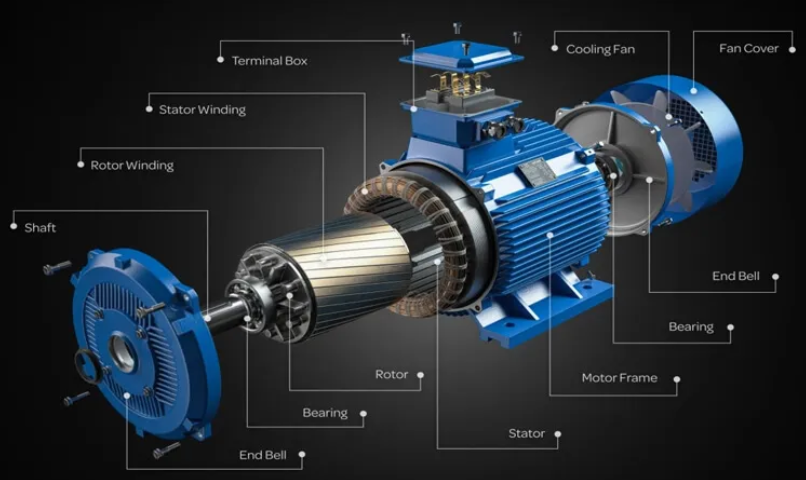

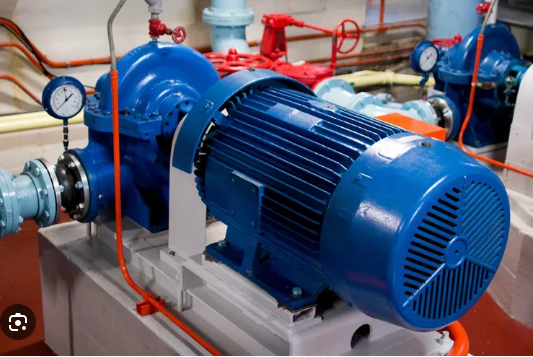

In [1322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [1323]:
df = pd.read_csv("/content/predictive_maintenance.csv")
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [1324]:
# Dropping 'UDI' and 'Product ID' from the dataset
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [1325]:
df.shape


(10000, 8)

In [1326]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10000 non-null  int64  
 7   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


In [1327]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [1328]:
# Taking a look at 'Failure Type' variable
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [1329]:
df['Target'].value_counts(normalize=True)

Target
0    0.9661
1    0.0339
Name: proportion, dtype: float64

In [1330]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [1331]:
df_failure = df[df['Target'] == 1]
df_failure['Failure Type'].value_counts()

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

In [1332]:
df_failure[df_failure['Failure Type'] == 'No Failure']

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
1437,H,298.8,309.9,1439,45.2,40,1,No Failure
2749,M,299.7,309.2,1685,28.9,179,1,No Failure
4044,M,301.9,310.9,1419,47.7,20,1,No Failure
4684,M,303.6,311.8,1421,44.8,101,1,No Failure
5536,M,302.3,311.8,1363,54.0,119,1,No Failure
5941,L,300.6,310.7,1438,48.5,78,1,No Failure
6478,L,300.5,309.8,1663,29.1,145,1,No Failure
8506,L,298.4,309.6,1710,27.3,163,1,No Failure
9015,L,297.2,308.1,1431,49.7,210,1,No Failure


In [1333]:
print('Missing values in the dataset : ',df.isna().sum().sum())
print('Duplicate values in the dataset : ',df.duplicated().sum())

Missing values in the dataset :  0
Duplicate values in the dataset :  0


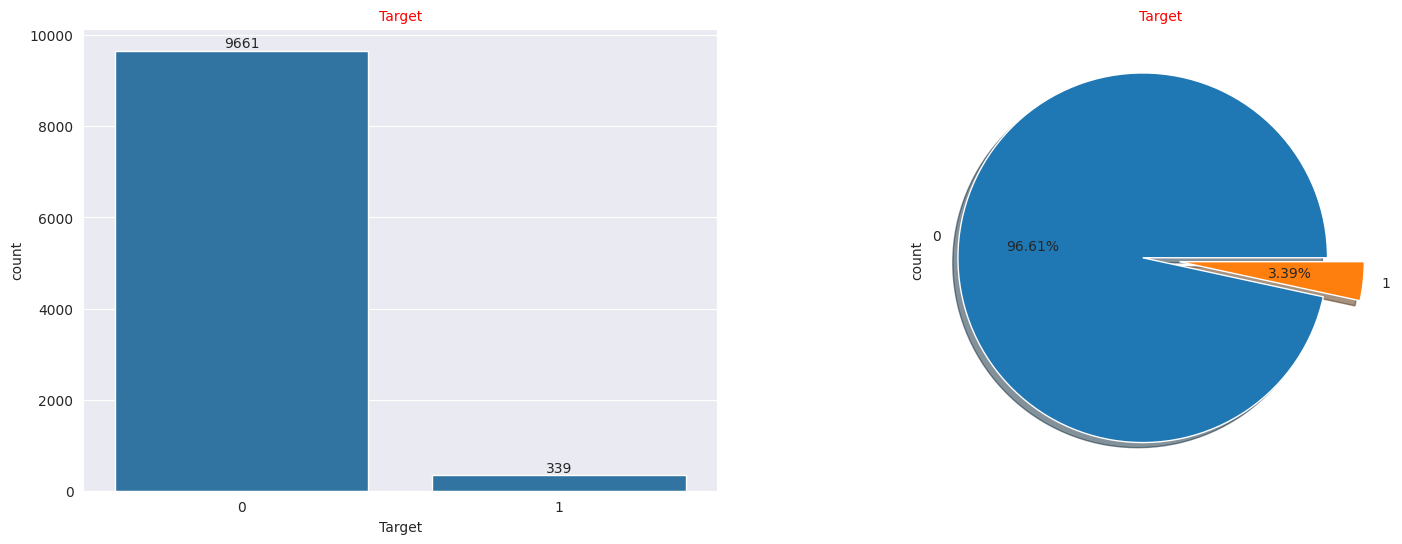

In [1334]:
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Target', data=df)
ax.bar_label(ax.containers[0])
plt.title("Target", fontsize=20,color='Red',font='Times New Roman')
ax =plt.subplot(1,2,2)
ax=df['Target'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Target", fontsize = 20,color='Red',font='Times New Roman');

In [1335]:
# Map the letter values to numerical values
type_mapping = {'L': 0, 'H': 1, 'M': 2}
df['Type'] = df['Type'].map(type_mapping)

# Alternatively, you can use the replace() function
df['Type'] = df['Type'].replace({'L': 0, 'H': 1, 'M': 2})

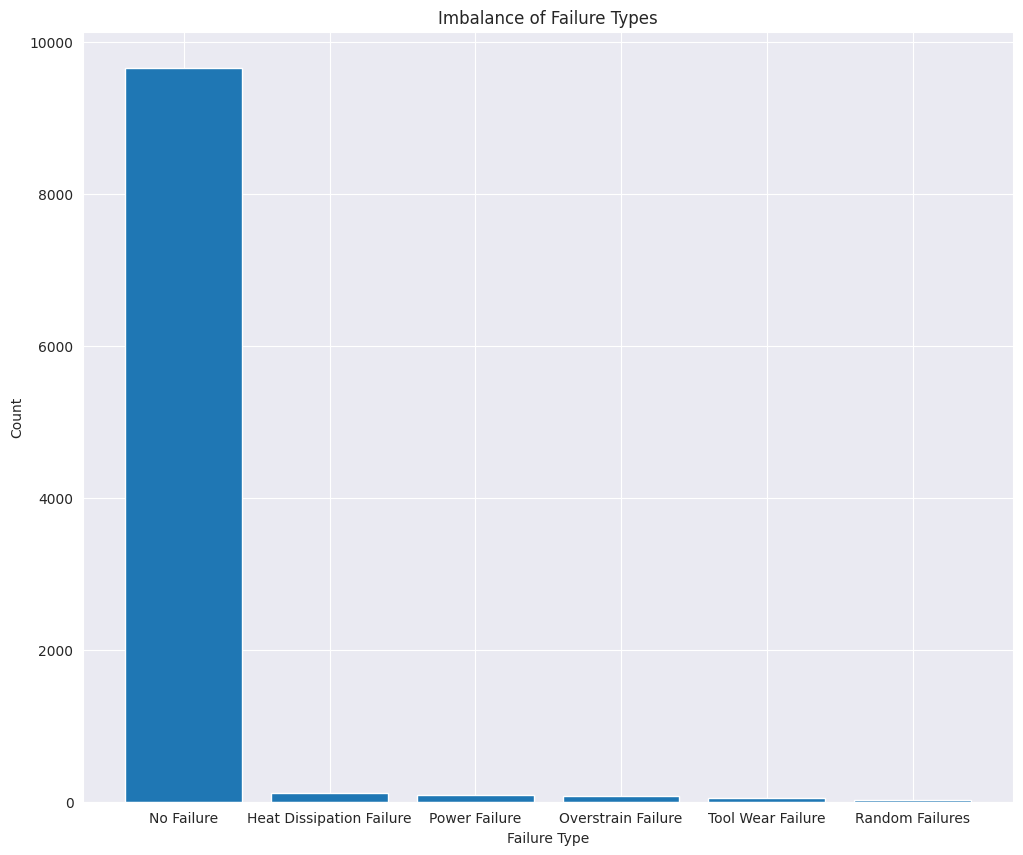

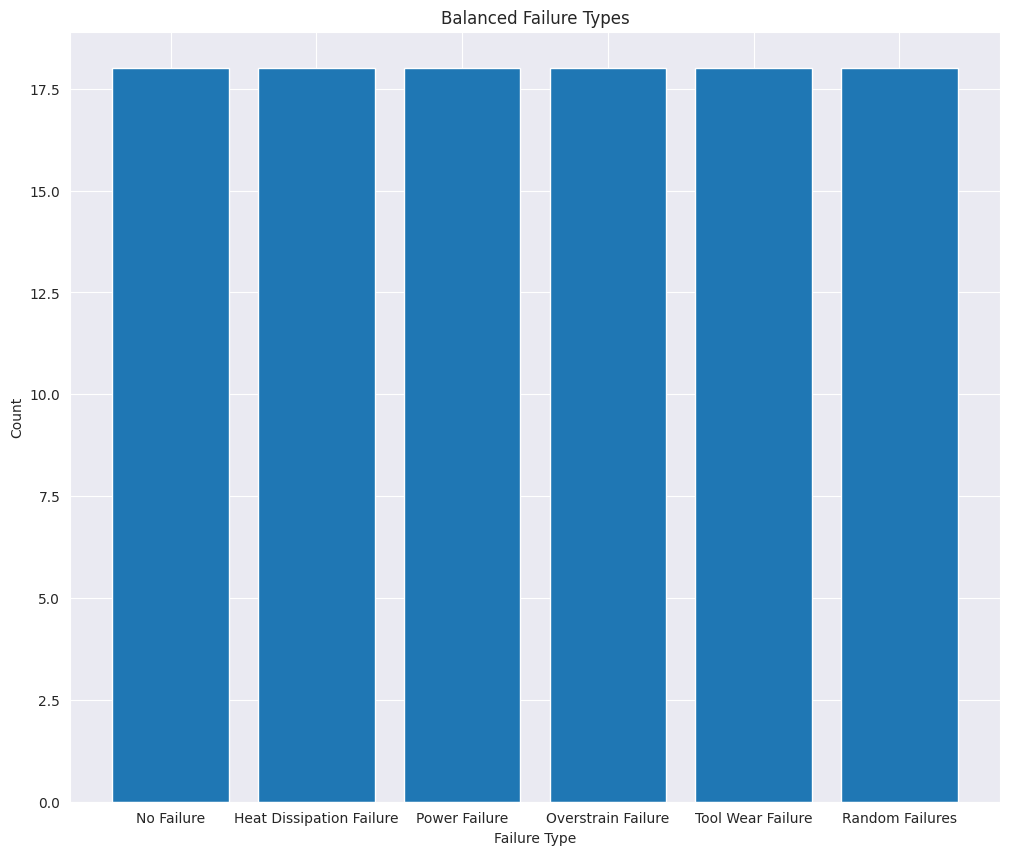

In [1336]:


# Count the occurrences of each unique value in the "Failure Type" column
value_counts = df['Failure Type'].value_counts()

# Plotting the data imbalance
plt.figure(figsize=(12, 10))
plt.bar(value_counts.index, value_counts.values)
plt.title('Imbalance of Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.show()

# Plotting the balanced data (with equal counts for each failure type)
plt.figure(figsize=(12, 10))
plt.bar(value_counts.index, [value_counts.min()] * len(value_counts))
plt.title('Balanced Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.show()

In [1337]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('Failure Type', axis=1)  # Features
y = df['Failure Type']  # Target variable

# Balance the target variable using oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Encode the target variable (y_resampled) with LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_resampled)

# One-hot encode the encoded target variable (y_encoded)
num_classes = len(np.unique(y_encoded))
y_onehot = np.eye(num_classes)[y_encoded]

# Standardize the features (X_resampled) using mean normalization
mean = np.mean(X_resampled, axis=0)
std = np.std(X_resampled, axis=0)
X_scaled = (X_resampled - mean) / std

In [1338]:
# Define softmax function
def softmax(z):
    e = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

# Define cross-entropy loss function
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / len(y_true)
    return loss

Iteration 100, Loss: 0.7912695305633901
Iteration 200, Loss: 0.6465194593610356
Iteration 300, Loss: 0.580885841663204
Iteration 400, Loss: 0.5407552485631829
Iteration 500, Loss: 0.5128688708779057
Iteration 600, Loss: 0.4920660450773455
Iteration 700, Loss: 0.4758155382812062
Iteration 800, Loss: 0.46269491344072083
Iteration 900, Loss: 0.4518314327597514
Iteration 1000, Loss: 0.442655634632247
Iteration 1100, Loss: 0.43477839346257263
Iteration 1200, Loss: 0.4279239568041249
Iteration 1300, Loss: 0.42189102360684827
Iteration 1400, Loss: 0.41652895109875027
Iteration 1500, Loss: 0.4117226042423381
Iteration 1600, Loss: 0.4073823742466407
Iteration 1700, Loss: 0.40343740861182237
Iteration 1800, Loss: 0.39983090220904577
Iteration 1900, Loss: 0.39651674873021664
Iteration 2000, Loss: 0.3934571124740274
Iteration 2100, Loss: 0.3906206365639623
Iteration 2200, Loss: 0.38798109999179214
Iteration 2300, Loss: 0.3855163968303255
Iteration 2400, Loss: 0.3832077504380205
Iteration 2500, Los

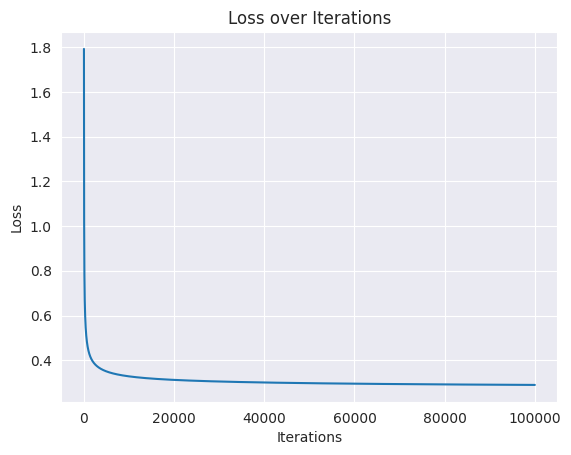

In [1339]:
# Define gradient descent function for logistic regression
def gradient_descent(X, y, learning_rate, num_iterations):
    num_samples, num_features = X.shape
    num_classes = y.shape[1]

    # Initialize the weights
    W = np.zeros((num_features, num_classes))

    losses = []  # Track the loss at each iteration

    for i in range(num_iterations):
        # Compute the logits
        scores = np.dot(X, W)

        # Compute the predicted probabilities using softmax
        probabilities = softmax(scores)

        # Compute the gradient
        gradient = np.dot(X.T, (probabilities - y)) / num_samples

        # Update the weights
        W -= learning_rate * gradient

        # Calculate the loss and add it to the list
        loss = cross_entropy_loss(y, probabilities)
        losses.append(loss)

        # Print the loss for every 50th iteration
        if (i + 1) % 100 == 0:
            print(f"Iteration {i+1}, Loss: {loss}")

    return W, losses
import random

# Set the random seed for reproducibility
random.seed(42)

# Combine X_scaled and y_onehot into a single DataFrame
data = np.concatenate((X_scaled, y_onehot), axis=1)

# Shuffle the data randomly
np.random.shuffle(data)

# Calculate the index to split the data into training and test sets
split_index = int(0.8 * len(data))  # 80% for training, 20% for testing

# Split the data into training and test sets
train_data = data[:split_index]
test_data = data[split_index:]

# Split the training and test sets into features (X) and target variable (y)
X_train = train_data[:, :-num_classes]
y_train = train_data[:, -num_classes:]
X_test = test_data[:, :-num_classes]
y_test = test_data[:, -num_classes:]

# Set parameters for gradient descent
learning_rate = 0.1
num_iterations = 100000

# Run gradient descent to optimize weights on the training set
W, losses = gradient_descent(X_train, y_train, learning_rate, num_iterations)

# Plot the loss over iterations
plt.plot(range(num_iterations), losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.show()




In [1340]:
# Make predictions on the training set
train_predictions = softmax(np.dot(X_train, W))
train_labels = np.argmax(y_train, axis=1)
train_accuracy = accuracy_score(train_labels, np.argmax(train_predictions, axis=1))

# Make predictions on the test set
test_predictions = softmax(np.dot(X_test, W))
test_labels = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(test_labels, np.argmax(test_predictions, axis=1))

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
# Make predictions on the entire dataset
all_predictions = softmax(np.dot(X_scaled, W))
all_labels = np.argmax(y_onehot, axis=1)
overall_accuracy = accuracy_score(all_labels, np.argmax(all_predictions, axis=1))

print(f"Overall Accuracy: {overall_accuracy}")

Training Accuracy: 0.8708584256081504
Test Accuracy: 0.8722265388932056
Overall Accuracy: 0.8711320624395634


## scikit-learn

In [1341]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import RandomOverSampler

# Read the dataset
df = pd.read_csv("/content/predictive_maintenance.csv")
# Dropping 'UDI' and 'Product ID' from the dataset
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

# Alternatively, you can use the replace() function
df['Type'] = df['Type'].replace({'L': 0, 'H': 1, 'M': 2})

# Split the features (X) and the target variable (y)
X = df.drop('Failure Type', axis=1)  # Features
y = df['Failure Type']  # Target variable

# Perform oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)


In [1342]:
# One-hot encode the target variable (y_resampled)
onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = onehot_encoder.fit_transform(y_resampled.values.reshape(-1, 1))

# Split the resampled data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Perform feature scaling on the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [1343]:
# Create and train the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_scaled, y_train)

LogisticRegression(multi_class='multinomial')

In [1344]:
# Perform feature scaling on the test set
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Print classification report
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.96      0.95      0.95      1881
              No Failure       0.72      0.65      0.68      1962
      Overstrain Failure       0.95      0.98      0.96      1933
           Power Failure       0.99      0.99      0.99      1957
         Random Failures       0.68      0.74      0.70      1916
       Tool Wear Failure       0.98      0.96      0.97      1934

                accuracy                           0.88     11583
               macro avg       0.88      0.88      0.88     11583
            weighted avg       0.88      0.88      0.88     11583



In [1345]:
# Make predictions on the training set
y_train_pred = model.predict(X_train_scaled)

# Print classification report for the training set
print("Classification Report - Training Set:")
print(classification_report(y_train, y_train_pred))

Classification Report - Training Set:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.95      0.95      0.95      7771
              No Failure       0.70      0.63      0.66      7690
      Overstrain Failure       0.95      0.97      0.96      7719
           Power Failure       0.99      0.99      0.99      7695
         Random Failures       0.67      0.73      0.69      7736
       Tool Wear Failure       0.98      0.96      0.97      7718

                accuracy                           0.87     46329
               macro avg       0.87      0.87      0.87     46329
            weighted avg       0.87      0.87      0.87     46329



In [1346]:
# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.875938875938876


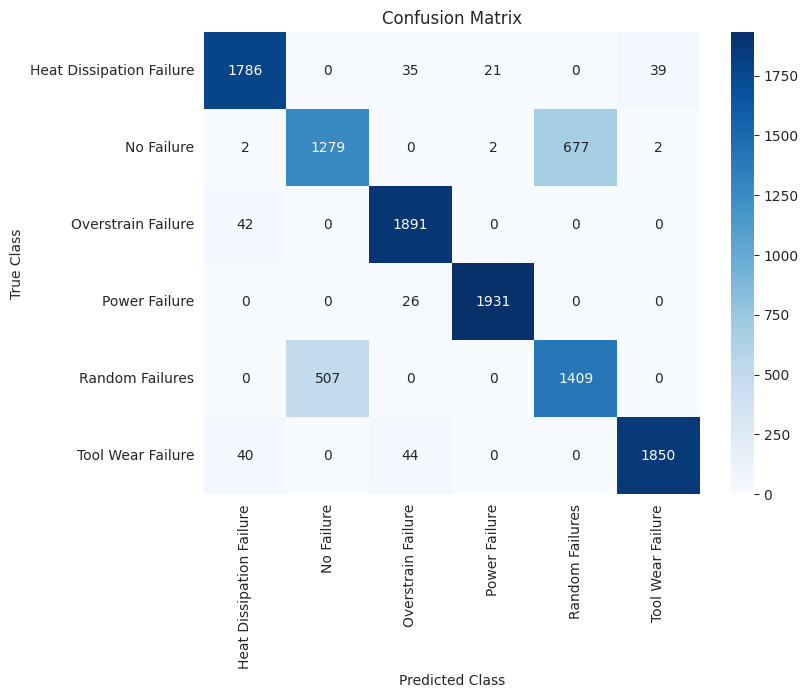

In [1347]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = sorted(df['Failure Type'].unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [1348]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1786    0   35   21    0   39]
 [   2 1279    0    2  677    2]
 [  42    0 1891    0    0    0]
 [   0    0   26 1931    0    0]
 [   0  507    0    0 1409    0]
 [  40    0   44    0    0 1850]]
